In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, classification_report, confusion_matrix
import joblib
import os

current_dir = os.getcwd()
if current_dir.endswith("notebooks"):
    project_root = os.path.dirname(current_dir)
elif current_dir.endswith("signal_synthesiser"):
    project_root = current_dir
else:
    project_root = os.path.dirname(current_dir) # Fallback

data_path = os.path.join(project_root, "data", "processed", "labelled_data.csv")

# Load Data
if os.path.exists(data_path):
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
    print(f"Data Loaded Successfully. Shape: {df.shape}")
else:
    print(f"Error: File not found at {data_path}. Did you run notebook 01?")

df.head()

Data Loaded Successfully. Shape: (2161, 24)


,Open,High,Low,Close,Volume,VIX,Returns,Volatility,RSI,SMA_50,...,BB_Std,BB_Upper,BB_Lower,VIX_Norm,Is_Friday,Signal_RSI,Signal_Trend,Signal_MACD,Signal_Bollinger,Target_Label
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-26,177.688302,178.114963,175.847842,176.266129,124308600,14.06,-0.010752,0.006775,57.009366,175.346309,...,1.398028,179.371751,173.779640,0.68,0,0,1,1,0,0
2015-05-27,176.726301,178.173571,176.316375,177.939331,93214000,13.27,0.009492,0.007071,66.666971,175.430751,...,1.429819,179.488039,173.768762,0.44,0,0,1,1,0,0
2015-05-28,177.629797,177.847302,177.044198,177.738556,74974600,13.31,-0.001128,0.007004,63.405644,175.521506,...,1.446027,179.599512,173.815402,0.48,0,0,1,1,0,0
2015-05-29,177.671588,177.713406,176.366535,176.634232,124919600,13.84,-0.006213,0.006751,47.993247,175.548531,...,1.340126,179.499807,174.139304,0.60,1,0,1,0,0,0
2015-06-01,177.303547,177.638172,176.199263,176.994019,93338800,13.97,0.002037,0.006326,54.217762,175.598744,...,1.334560,179.524231,174.185991,0.70,0,0,1,0,0,0


In [2]:
# Time-Series Split
# We use data up to 2020 for training, 2020-2022 for validation, and the rest for final testing.

# Define dates
train_end = "2020-01-01"
val_end = "2022-01-01"

# Split Data
train = df[df.index < train_end]
val = df[(df.index >= train_end) & (df.index < val_end)]
test = df[df.index >= val_end]

print(f"Training Set:   {train.shape[0]} days")
print(f"Validation Set: {val.shape[0]} days")
print(f"Test Set:       {test.shape[0]} days")

Training Set:   1160 days
Validation Set: 505 days
Test Set:       496 days


In [3]:
# Feature Selection

# The Inputs (X)
features = ['Signal_RSI', 'Signal_Trend', 'Signal_MACD', 'Signal_Bollinger', 
            'Volatility', 'VIX_Norm', 'Is_Friday', 'Volume']

# The Output (y)
target = 'Target_Label'

# Create X and y matrices
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

print(f"Training with {len(features)} features: {features}")

Training with 8 features: ['Signal_RSI', 'Signal_Trend', 'Signal_MACD', 'Signal_Bollinger', 'Volatility', 'VIX_Norm', 'Is_Friday', 'Volume']


In [4]:
# Train Random Forest

# n_estimators=200: 200 Decision Trees
# min_samples_leaf=50: High number to prevent overfitting 
# class_weight='balanced': Handle the fact that wins might be rare
model = RandomForestClassifier(
    n_estimators=200, 
    min_samples_leaf=50, 
    random_state=42, 
    class_weight='balanced_subsample'
)

print("Training model...")
model.fit(X_train, y_train)
print("Training Complete.")

Training model...
Training Complete.


Model Precision: 65.13%


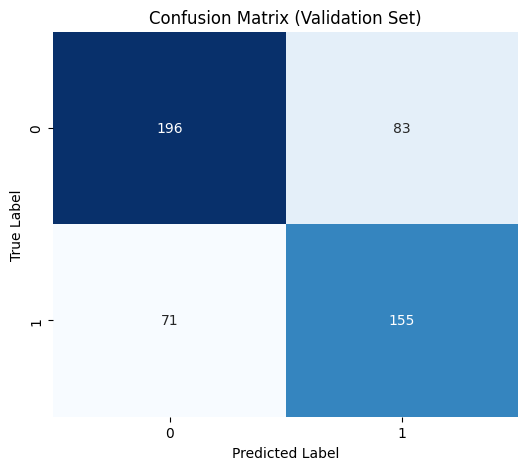


Full Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       279
           1       0.65      0.69      0.67       226

    accuracy                           0.70       505
   macro avg       0.69      0.69      0.69       505
weighted avg       0.70      0.70      0.70       505



In [5]:
# Evaluate Performance

# Get Predictions
preds = model.predict(X_val)

# Calculate Metrics
precision = precision_score(y_val, preds)
print(f"Model Precision: {precision:.2%}")

# The Confusion Matrix
cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

print("\nFull Report:")
print(classification_report(y_val, preds))

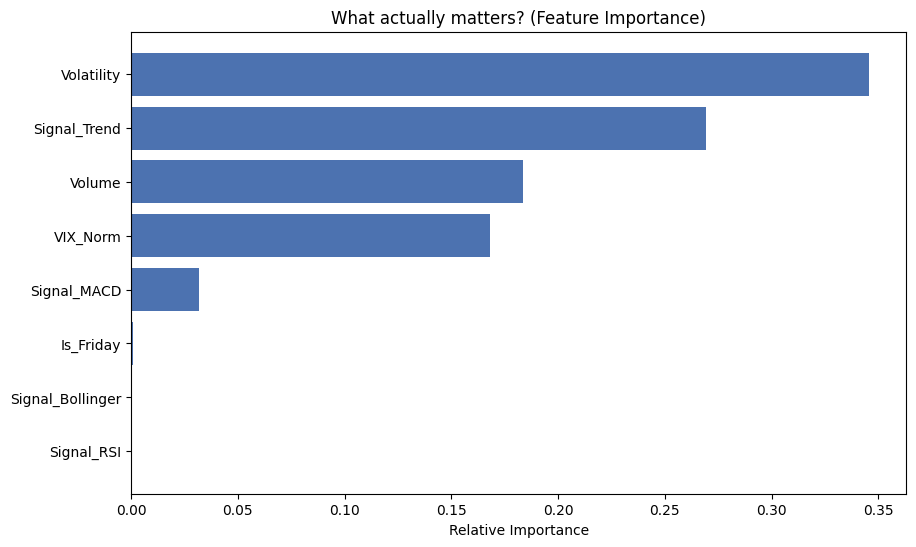

In [6]:
# Feature Importance Plot
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('What actually matters? (Feature Importance)')
plt.barh(range(len(indices)), importances[indices], color='#4c72b0', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [8]:
# Save Model
save_dir = os.path.join(project_root, "models")
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "rf_v1.joblib")
joblib.dump(model, model_path)

print(f"Model saved to {model_path}")

Model saved to /mnt/c/Users/sohan/Projects/signal_synthesiser/models/rf_v1.joblib
